In [ ]:
import os
import numpy as np
import time
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import matplotlib
import math

# np.random.seed(9630)
# tf.random.set_seed(9630)

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

4431872/4422102 [==============================] - 0s 0us/step


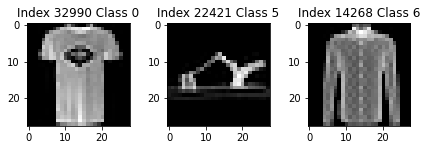

In [ ]:
# Load MNIST or Fashion MNIST
# (X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
assert X_train.shape == (60000, 28, 28)
assert X_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

# Display randomly selected data
indices = list(np.random.randint(X_train.shape[0],size=3))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(X_train[indices[i]].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Index {} Class {}".format(indices[i], y_train[indices[i]]))
    plt.tight_layout()

In [ ]:
# Split train dataset into train and validation
X_val = X_train[50000:60000]
X_train = X_train[0:50000]
y_val = y_train[50000:60000]
y_train = y_train[0:50000]

print("size of training set is", str(X_train.shape[0]), "samples")
print("every train example is", str(X_train.shape[1]), "by", str(X_train.shape[2]))

print("size of validation set is", str(X_val.shape[0]), "samples")
print("every validation example is", str(X_val.shape[1]), "by", str(X_val.shape[2]))

X_train = X_train.reshape(50000, 28*28)
X_val = X_val.reshape(10000, 28*28)
X_test = X_test.reshape(10000, 28*28)

print("size of training set is", str(X_train.shape[0]), "samples")
print("every train example has", str(X_train.shape[1]), "features")

print("size of validation set is", str(X_val.shape[0]), "samples")
print("every validation example has", str(X_val.shape[1]), "features")

size of training set is 50000 samples
every train example is 28 by 28
size of validation set is 10000 samples
every validation example is 28 by 28
size of training set is 50000 samples
every train example has 784 features
size of validation set is 10000 samples
every validation example has 784 features


In [ ]:
#Normalize Data

X_train = X_train/255
X_val = X_val/255
X_test = X_test/255
# X_train[0]
np.max(X_train)

1.0

In [ ]:
size_input = X_train.shape[1]
size_hidden1 = 128
size_hidden2 = 128
size_hidden3 = 128
size_output = 10

lr = 0.01
dropout_p = 0.0
L2 = 0.0

number_of_train_examples = X_train.shape[0]
number_of_test_examples = X_test.shape[0]

y_train = tf.keras.utils.to_categorical(y_train, num_classes=10) # Other function is tf.one_hot(y_train,depth=10)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)
print(tf.shape(y_val))

tf.Tensor([10000    10], shape=(2,), dtype=int32)


In [ ]:
class MLP(object):
  def __init__(self, size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device=None):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """

    self.size_input, self.size_hidden1, self.size_hidden2, self.size_hidden3, self.size_output, self.device =\
    size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device
    
    # Initialize weights between input mapping and a layer g(f(x)) = layer
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_hidden1],stddev=0.1)) # Xavier(Fan-in fan-out) and Orthogonal
    # Initialize biases for hidden layer
    self.b1 = tf.Variable(tf.zeros([1, self.size_hidden1])) # 0 or constant(0.01)
    
    # Initialize weights between input layer and 1st hidden layer
    self.W2 = tf.Variable(tf.random.normal([self.size_hidden1, self.size_hidden2],stddev=0.1))
    # Initialize biases for hidden layer
    self.b2 = tf.Variable(tf.zeros([1, self.size_hidden2]))
    
    # Initialize weights between 1st hidden layer and 2nd hidden layer
    self.W3 = tf.Variable(tf.random.normal([self.size_hidden2, self.size_hidden3],stddev=0.1))
    # Initialize biases for hidden layer
    self.b3 = tf.Variable(tf.zeros([1, self.size_hidden3]))
    
     # Initialize weights between 2nd hidden layer and output layer
    self.W4 = tf.Variable(tf.random.normal([self.size_hidden3, self.size_output],stddev=0.1))
    # Initialize biases for output layer
    self.b4 = tf.Variable(tf.zeros([1, self.size_output]))

    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.W4, self.b1, self.b2, self.b3, self.b4]

    self.loss_object =tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    # self.loss_object =tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)    
    self.reg_12=tf.keras.regularizers.L2(l2=L2)

    self.t=0
    self.m=[tf.zeros_like(self.W1,dtype=tf.float32), tf.zeros_like(self.W2,dtype=tf.float32),tf.zeros_like(self.W3,dtype=tf.float32),tf.zeros_like(self.W4,dtype=tf.float32),tf.zeros_like(self.b1,dtype=tf.float32),tf.zeros_like(self.b2,dtype=tf.float32),tf.zeros_like(self.b3,dtype=tf.float32),tf.zeros_like(self.b4,dtype=tf.float32)]
    self.v=[tf.zeros_like(self.W1,dtype=tf.float32), tf.zeros_like(self.W2,dtype=tf.float32),tf.zeros_like(self.W3,dtype=tf.float32),tf.zeros_like(self.W4,dtype=tf.float32),tf.zeros_like(self.b1,dtype=tf.float32),tf.zeros_like(self.b2,dtype=tf.float32),tf.zeros_like(self.b3,dtype=tf.float32),tf.zeros_like(self.b4,dtype=tf.float32)]
    self.u=[tf.zeros_like(self.W1,dtype=tf.float32), tf.zeros_like(self.W2,dtype=tf.float32),tf.zeros_like(self.W3,dtype=tf.float32),tf.zeros_like(self.W4,dtype=tf.float32),tf.zeros_like(self.b1,dtype=tf.float32),tf.zeros_like(self.b2,dtype=tf.float32),tf.zeros_like(self.b3,dtype=tf.float32),tf.zeros_like(self.b4,dtype=tf.float32)]
    
  def forward(self, training, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if training==1:
      if self.device is not None:
        with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
          self.y = self.compute_output(X)
      else:
        self.y = self.compute_output(X)
    elif training==0:
      if self.device is not None:
        with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
          self.y = self.compute_output_test(X)
      else:
        self.y = self.compute_output_test(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    loss_x = self.loss_object(y_true_tf, y_pred)+self.reg_12(self.W1)+self.reg_12(self.W2)+self.reg_12(self.W3)
    return loss_x
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """

    '''
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr)
    with tf.GradientTape() as tape:
      predicted = self.forward(1,X_train)
      current_loss = self.loss(predicted, y_train)
    grads = tape.gradient(current_loss, self.MLP_variables)
    optimizer.apply_gradients(zip(grads, self.MLP_variables))
    '''

    self.t=self.t+1
    beta_1=0.9
    beta_2=0.999
    beta_3=0.999987
    ep=1e-8
    
    with tf.GradientTape() as tape:
      predicted = self.forward(1,X_train)
      current_loss = self.loss(predicted, y_train)
    grads = tape.gradient(current_loss, self.variables)


    self.m=[a_i*beta_1+(1-beta_1)*b_i for a_i, b_i in zip(self.m, grads)]
    self.v=[a_i*beta_2+(1-beta_2)*(b_i**2) for a_i, b_i in zip(self.v, grads)]
    self.u=[a_i*beta_3+(1-beta_3)*(b_i**3) for a_i, b_i in zip(self.u, grads)]

    mhat=[a_i/(1-(beta_1**self.t)) for a_i in self.m]
    vhat=[a_i/(1-(beta_2**self.t)) for a_i in self.v]
    uhat=[a_i/(1-(beta_3**self.t)) for a_i in self.u]
    uhat_sign=[tf.math.sign(a_i) for a_i in uhat]
    uhat_abs=[tf.abs(a_i) for a_i in uhat]

    dws_new=[lr * a_i /(ep + tf.sqrt(b_i)+(d_i*tf.pow(c_i,1.0/3.0)*ep)) for a_i, b_i, c_i, d_i in zip(mhat, vhat, uhat_abs, uhat_sign)]

    #print(type(dws[0:1]))
    Wt = [a_i - b_i for a_i, b_i in zip(self.variables, dws_new)]
    #print(type(Wt))

    for i in range(len(self.variables)):
      self.variables[i].assign(Wt[i])

        
  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward

    # Compute values in hidden layer
    z1 = tf.matmul(X_tf, self.W1) + self.b1
    h1 = tf.nn.relu(z1)
    h1 = tf.nn.dropout(h1, rate = dropout_p, seed = seed)
    
    z2 = tf.matmul(h1, self.W2) + self.b2
    h2 = tf.nn.relu(z2)
    h2 = tf.nn.dropout(h2, rate = dropout_p, seed = seed)

    z3 = tf.matmul(h2, self.W3) + self.b3
    h3 = tf.nn.relu(z3)
    h3 = tf.nn.dropout(h3, rate = dropout_p, seed = seed)  

    # Compute output
    output = tf.matmul(h3, self.W4) + self.b4
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output

  def compute_output_test(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward

    # Compute values in hidden layer
    z1 = tf.matmul(X_tf, self.W1) + self.b1
    h1 = tf.nn.relu(z1)

    z2 = tf.matmul(h1, self.W2) + self.b2
    h2 = tf.nn.relu(z2)

    z3 = tf.matmul(h2, self.W3) + self.b3
    h3 = tf.nn.relu(z3)    

    # Compute output
    output = tf.matmul(h3, self.W4) + self.b4
    #Now consider two things , First look at inbuild loss functions if they work with softmax or not and then change this
    #Second add tf.Softmax(output) and then return this variable
    return output

# Without regularization

======================= Trial: 1 =======================

Train Accuracy: 0.8532
Number of Epoch = 1 - Average Cross Entropy:= 0.004355409545898438 

Validation Accuracy: 0.8432

Train Accuracy: 0.8716
Number of Epoch = 2 - Average Cross Entropy:= 0.0032220767211914064 

Validation Accuracy: 0.8587

Train Accuracy: 0.8725
Number of Epoch = 3 - Average Cross Entropy:= 0.0029600247192382812 

Validation Accuracy: 0.8613

Train Accuracy: 0.8724
Number of Epoch = 4 - Average Cross Entropy:= 0.0028299819946289062 

Validation Accuracy: 0.8590

Train Accuracy: 0.8863
Number of Epoch = 5 - Average Cross Entropy:= 0.00273883544921875 

Validation Accuracy: 0.8676

Train Accuracy: 0.8784
Number of Epoch = 6 - Average Cross Entropy:= 0.0026672067260742186 

Validation Accuracy: 0.8584

Train Accuracy: 0.8726
Number of Epoch = 7 - Average Cross Entropy:= 0.00261233154296875 

Validation Accuracy: 0.8529

Train Accuracy: 0.8892
Number of Epoch = 8 - Average Cross Entropy:= 0.0025920816040039063 



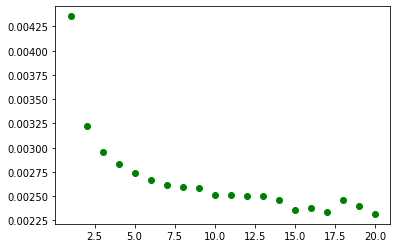


Test Accuracy = 0.8698

Total time taken (in seconds): 358.38
======================= Trial: 2 =======================

Train Accuracy: 0.9003
Number of Epoch = 1 - Average Cross Entropy:= 0.0022814958190917967 

Validation Accuracy: 0.8762

Train Accuracy: 0.9010
Number of Epoch = 2 - Average Cross Entropy:= 0.002331156768798828 

Validation Accuracy: 0.8722

Train Accuracy: 0.8939
Number of Epoch = 3 - Average Cross Entropy:= 0.002232471923828125 

Validation Accuracy: 0.8694

Train Accuracy: 0.8942
Number of Epoch = 4 - Average Cross Entropy:= 0.0022179750061035158 

Validation Accuracy: 0.8699

Train Accuracy: 0.8962
Number of Epoch = 5 - Average Cross Entropy:= 0.0022322537231445313 

Validation Accuracy: 0.8722

Train Accuracy: 0.9034
Number of Epoch = 6 - Average Cross Entropy:= 0.002214146270751953 

Validation Accuracy: 0.8766

Train Accuracy: 0.8990
Number of Epoch = 7 - Average Cross Entropy:= 0.0021953572082519532 

Validation Accuracy: 0.8702

Train Accuracy: 0.9056
Numbe

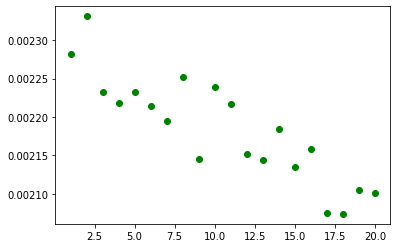


Test Accuracy = 0.8595

Total time taken (in seconds): 356.53
======================= Trial: 3 =======================

Train Accuracy: 0.9098
Number of Epoch = 1 - Average Cross Entropy:= 0.0021120809936523437 

Validation Accuracy: 0.8767

Train Accuracy: 0.9129
Number of Epoch = 2 - Average Cross Entropy:= 0.0020945440673828127 

Validation Accuracy: 0.8778

Train Accuracy: 0.9076
Number of Epoch = 3 - Average Cross Entropy:= 0.0020659022521972658 

Validation Accuracy: 0.8719

Train Accuracy: 0.9128
Number of Epoch = 4 - Average Cross Entropy:= 0.0020317706298828126 

Validation Accuracy: 0.8771

Train Accuracy: 0.9121
Number of Epoch = 5 - Average Cross Entropy:= 0.0020705741882324218 

Validation Accuracy: 0.8768

Train Accuracy: 0.9111
Number of Epoch = 6 - Average Cross Entropy:= 0.002253435516357422 

Validation Accuracy: 0.8763

Train Accuracy: 0.9125
Number of Epoch = 7 - Average Cross Entropy:= 0.00202752197265625 

Validation Accuracy: 0.8746

Train Accuracy: 0.8837
Numbe

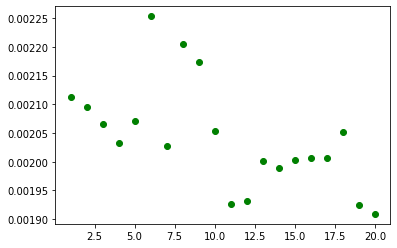


Test Accuracy = 0.8711

Total time taken (in seconds): 352.32
======================= Trial: 4 =======================

Train Accuracy: 0.9203
Number of Epoch = 1 - Average Cross Entropy:= 0.002016519012451172 

Validation Accuracy: 0.8787

Train Accuracy: 0.9128
Number of Epoch = 2 - Average Cross Entropy:= 0.0020085752868652345 

Validation Accuracy: 0.8759

Train Accuracy: 0.9132
Number of Epoch = 3 - Average Cross Entropy:= 0.002021454162597656 

Validation Accuracy: 0.8731

Train Accuracy: 0.9078
Number of Epoch = 4 - Average Cross Entropy:= 0.0019829881286621094 

Validation Accuracy: 0.8704

Train Accuracy: 0.9162
Number of Epoch = 5 - Average Cross Entropy:= 0.001994044952392578 

Validation Accuracy: 0.8770

Train Accuracy: 0.9039
Number of Epoch = 6 - Average Cross Entropy:= 0.0019142724609375 

Validation Accuracy: 0.8690

Train Accuracy: 0.9146
Number of Epoch = 7 - Average Cross Entropy:= 0.0019187257385253906 

Validation Accuracy: 0.8731

Train Accuracy: 0.9141
Number o

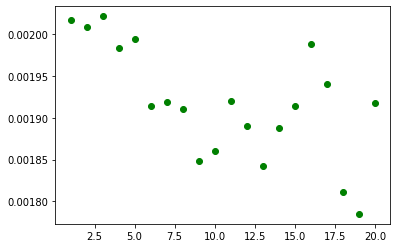


Test Accuracy = 0.8697

Total time taken (in seconds): 348.28
======================= Trial: 5 =======================

Train Accuracy: 0.8972
Number of Epoch = 1 - Average Cross Entropy:= 0.0019156776428222656 

Validation Accuracy: 0.8614

Train Accuracy: 0.9191
Number of Epoch = 2 - Average Cross Entropy:= 0.001920997314453125 

Validation Accuracy: 0.8795

Train Accuracy: 0.9176
Number of Epoch = 3 - Average Cross Entropy:= 0.0017782852172851563 

Validation Accuracy: 0.8771

Train Accuracy: 0.9167
Number of Epoch = 4 - Average Cross Entropy:= 0.0017827679443359376 

Validation Accuracy: 0.8731

Train Accuracy: 0.9151
Number of Epoch = 5 - Average Cross Entropy:= 0.002057306671142578 

Validation Accuracy: 0.8741

Train Accuracy: 0.8976
Number of Epoch = 6 - Average Cross Entropy:= 0.001811313934326172 

Validation Accuracy: 0.8616

Train Accuracy: 0.9229
Number of Epoch = 7 - Average Cross Entropy:= 0.00189476806640625 

Validation Accuracy: 0.8782

Train Accuracy: 0.9208
Number 

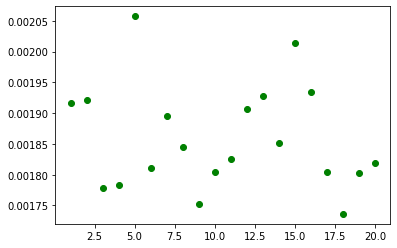


Test Accuracy = 0.8717

Total time taken (in seconds): 342.46
======================= Trial: 6 =======================

Train Accuracy: 0.9198
Number of Epoch = 1 - Average Cross Entropy:= 0.0017143748474121093 

Validation Accuracy: 0.8717

Train Accuracy: 0.9201
Number of Epoch = 2 - Average Cross Entropy:= 0.001773153076171875 

Validation Accuracy: 0.8745

Train Accuracy: 0.9114
Number of Epoch = 3 - Average Cross Entropy:= 0.0018791615295410157 

Validation Accuracy: 0.8716

Train Accuracy: 0.9084
Number of Epoch = 4 - Average Cross Entropy:= 0.0018164190673828125 

Validation Accuracy: 0.8656

Train Accuracy: 0.9181
Number of Epoch = 5 - Average Cross Entropy:= 0.0018854615783691407 

Validation Accuracy: 0.8762

Train Accuracy: 0.9205
Number of Epoch = 6 - Average Cross Entropy:= 0.0019125039672851563 

Validation Accuracy: 0.8716

Train Accuracy: 0.9120
Number of Epoch = 7 - Average Cross Entropy:= 0.0017752059936523438 

Validation Accuracy: 0.8670

Train Accuracy: 0.9199
Num

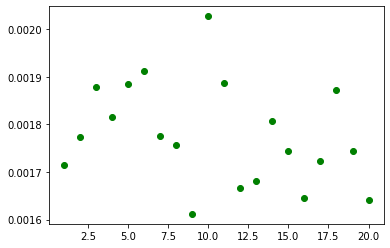


Test Accuracy = 0.8671

Total time taken (in seconds): 345.61
======================= Trial: 7 =======================

Train Accuracy: 0.9166
Number of Epoch = 1 - Average Cross Entropy:= 0.0018376919555664062 

Validation Accuracy: 0.8716

Train Accuracy: 0.9238
Number of Epoch = 2 - Average Cross Entropy:= 0.0017606094360351563 

Validation Accuracy: 0.8771

Train Accuracy: 0.9072
Number of Epoch = 3 - Average Cross Entropy:= 0.002065349884033203 

Validation Accuracy: 0.8653

Train Accuracy: 0.9148
Number of Epoch = 4 - Average Cross Entropy:= 0.001993104248046875 

Validation Accuracy: 0.8729

Train Accuracy: 0.9172
Number of Epoch = 5 - Average Cross Entropy:= 0.0018439599609375 

Validation Accuracy: 0.8746

Train Accuracy: 0.9182
Number of Epoch = 6 - Average Cross Entropy:= 0.001785360565185547 

Validation Accuracy: 0.8720

Train Accuracy: 0.9247
Number of Epoch = 7 - Average Cross Entropy:= 0.0017554185485839844 

Validation Accuracy: 0.8780

Train Accuracy: 0.9194
Number o

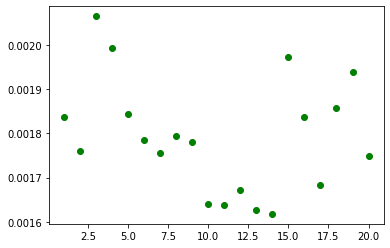


Test Accuracy = 0.8653

Total time taken (in seconds): 342.75
======================= Trial: 8 =======================

Train Accuracy: 0.9157
Number of Epoch = 1 - Average Cross Entropy:= 0.0017708102416992188 

Validation Accuracy: 0.8709

Train Accuracy: 0.9267
Number of Epoch = 2 - Average Cross Entropy:= 0.0018222291564941406 

Validation Accuracy: 0.8755

Train Accuracy: 0.9225
Number of Epoch = 3 - Average Cross Entropy:= 0.0016170098876953124 

Validation Accuracy: 0.8731

Train Accuracy: 0.9255
Number of Epoch = 4 - Average Cross Entropy:= 0.001649120330810547 

Validation Accuracy: 0.8731

Train Accuracy: 0.9170
Number of Epoch = 5 - Average Cross Entropy:= 0.00156380859375 

Validation Accuracy: 0.8686

Train Accuracy: 0.9258
Number of Epoch = 6 - Average Cross Entropy:= 0.001964701843261719 

Validation Accuracy: 0.8743

Train Accuracy: 0.9299
Number of Epoch = 7 - Average Cross Entropy:= 0.001651778106689453 

Validation Accuracy: 0.8791

Train Accuracy: 0.9290
Number of 

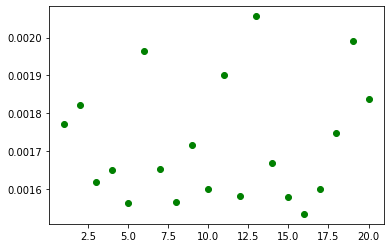


Test Accuracy = 0.8696

Total time taken (in seconds): 340.75
======================= Trial: 9 =======================

Train Accuracy: 0.9133
Number of Epoch = 1 - Average Cross Entropy:= 0.0018594375610351563 

Validation Accuracy: 0.8660

Train Accuracy: 0.9261
Number of Epoch = 2 - Average Cross Entropy:= 0.00162728271484375 

Validation Accuracy: 0.8777

Train Accuracy: 0.9223
Number of Epoch = 3 - Average Cross Entropy:= 0.0016511184692382813 

Validation Accuracy: 0.8714

Train Accuracy: 0.9284
Number of Epoch = 4 - Average Cross Entropy:= 0.0015151329040527343 

Validation Accuracy: 0.8760

Train Accuracy: 0.9193
Number of Epoch = 5 - Average Cross Entropy:= 0.0015945307922363282 

Validation Accuracy: 0.8684

Train Accuracy: 0.9240
Number of Epoch = 6 - Average Cross Entropy:= 0.0015738356018066405 

Validation Accuracy: 0.8747

Train Accuracy: 0.9223
Number of Epoch = 7 - Average Cross Entropy:= 0.0016563670349121094 

Validation Accuracy: 0.8728

Train Accuracy: 0.9233
Numb

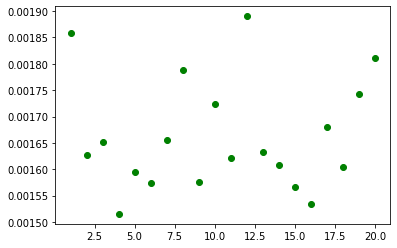


Test Accuracy = 0.8648

Total time taken (in seconds): 340.27
======================= Trial: 10 =======================

Train Accuracy: 0.9150
Number of Epoch = 1 - Average Cross Entropy:= 0.0018215225219726562 

Validation Accuracy: 0.8676

Train Accuracy: 0.9255
Number of Epoch = 2 - Average Cross Entropy:= 0.0015828190612792968 

Validation Accuracy: 0.8753

Train Accuracy: 0.9235
Number of Epoch = 3 - Average Cross Entropy:= 0.001738261260986328 

Validation Accuracy: 0.8737

Train Accuracy: 0.9230
Number of Epoch = 4 - Average Cross Entropy:= 0.0015174949645996095 

Validation Accuracy: 0.8697

Train Accuracy: 0.9211
Number of Epoch = 5 - Average Cross Entropy:= 0.0015488723754882813 

Validation Accuracy: 0.8708

Train Accuracy: 0.9054
Number of Epoch = 6 - Average Cross Entropy:= 0.0016921846008300782 

Validation Accuracy: 0.8556

Train Accuracy: 0.9200
Number of Epoch = 7 - Average Cross Entropy:= 0.0019400360107421875 

Validation Accuracy: 0.8715

Train Accuracy: 0.9248
Nu

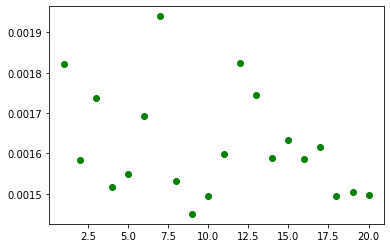


Test Accuracy = 0.865

Total time taken (in seconds): 339.83
Test Accuracy [0.8698, 0.8595, 0.8711, 0.8697, 0.8717, 0.8671, 0.8653, 0.8696, 0.8648, 0.865]


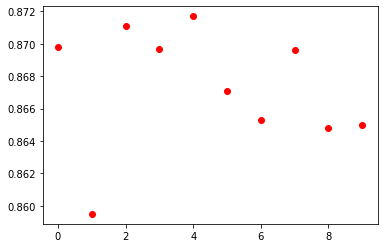

In [ ]:
# 10 Trials for Stability Test
# Set number of epochs
NUM_EPOCHS = 20

seeds = [9630]
seeds = np.random.randint(1000,9999,10)
test_acc_total = []

# Initialize model using CPU
mlp_on_cpu = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device='gpu')

time_start_total = time.time()

for i in range(len(seeds)):
  time_start = time.time()
  seed = seeds[i]
  print('======================= Trial:', i+1, '=======================')
  for epoch in range(NUM_EPOCHS):
      
    loss_total = tf.zeros([1,1], dtype=tf.float32)
    lt = 0
      
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(seed)).batch(128)
    kz = 0
    accuracy_z = 0.0
    cur_train_acc = 0.0
    for inputs, outputs in train_ds:
      qw, tr = tf.shape(inputs)
      kz = kz + 1
      preds = mlp_on_cpu.forward(0, inputs) 
      loss_total = loss_total + mlp_on_cpu.loss(preds, outputs)
      lt = lt + mlp_on_cpu.loss(preds, outputs)
      mlp_on_cpu.backward(inputs, outputs)

    preds = mlp_on_cpu.forward(0, X_train)
    # Get probs, remember we only have logits from our forward function, we need to apply softmax on top of it to get probs
    preds = tf.nn.softmax(preds)
    correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(y_train, 1))
    accuracy_z = accuracy_z + tf.reduce_mean(tf.cast(correct_prediction, "float"))
    cur_train_acc += accuracy_z.numpy()
    ds = cur_train_acc
    print('\nTrain Accuracy: {:.4f}'.format(ds))
    print('Number of Epoch = {} - Average Cross Entropy:= {} '.format(epoch + 1, np.sum(loss_total) / X_train.shape[0]))
    
    preds_val = mlp_on_cpu.forward(0, X_val)
    preds_val = tf.nn.softmax(preds_val)
    correct_prediction = tf.equal(tf.argmax(preds_val, 1), tf.argmax(y_val, 1))

    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    cur_val_acc = accuracy.numpy()

    print('\nValidation Accuracy: {:.4f}'.format(cur_val_acc))
    
    plt.plot(epoch + 1, np.sum(loss_total) / X_train.shape[0], 'go')

  plt.show()        
  time_taken = time.time() - time_start
      
  # Validate model
      
  # Test Model
  preds = mlp_on_cpu.forward(0, X_test)
  pred = np.argmax(preds, axis = 1)
  y_true = np.argmax(y_test, axis = 1)
  test_acc = (pred==y_true).mean()
  test_acc_total.append(test_acc)

  print('\nTest Accuracy = {}'.format(test_acc))

  print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
  #For per epoch_time = Total_Time / Number_of_epochs
print('Test Accuracy', test_acc_total)
plt.plot(test_acc_total, 'ro')
plt.show()

# Dropout

======================= Trial: 1 =======================

Train Accuracy: 0.8059
Number of Epoch = 1 - Average Cross Entropy:= 0.004647484741210938 

Validation Accuracy: 0.7959

Train Accuracy: 0.8460
Number of Epoch = 2 - Average Cross Entropy:= 0.0036790536499023436 

Validation Accuracy: 0.8389

Train Accuracy: 0.8514
Number of Epoch = 3 - Average Cross Entropy:= 0.0035583322143554687 

Validation Accuracy: 0.8413

Train Accuracy: 0.8406
Number of Epoch = 4 - Average Cross Entropy:= 0.0034354388427734377 

Validation Accuracy: 0.8319

Train Accuracy: 0.8564
Number of Epoch = 5 - Average Cross Entropy:= 0.0034705630493164063 

Validation Accuracy: 0.8453

Train Accuracy: 0.8474
Number of Epoch = 6 - Average Cross Entropy:= 0.003398224792480469 

Validation Accuracy: 0.8394

Train Accuracy: 0.8542
Number of Epoch = 7 - Average Cross Entropy:= 0.00335256103515625 

Validation Accuracy: 0.8407

Train Accuracy: 0.8524
Number of Epoch = 8 - Average Cross Entropy:= 0.003321783142089844 



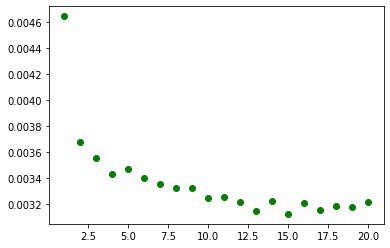


Test Accuracy = 0.8145

Total time taken (in seconds): 367.08
======================= Trial: 2 =======================

Train Accuracy: 0.8569
Number of Epoch = 1 - Average Cross Entropy:= 0.003193226013183594 

Validation Accuracy: 0.8431

Train Accuracy: 0.8575
Number of Epoch = 2 - Average Cross Entropy:= 0.003369085693359375 

Validation Accuracy: 0.8445

Train Accuracy: 0.8671
Number of Epoch = 3 - Average Cross Entropy:= 0.003165403747558594 

Validation Accuracy: 0.8522

Train Accuracy: 0.8588
Number of Epoch = 4 - Average Cross Entropy:= 0.0031621682739257813 

Validation Accuracy: 0.8440

Train Accuracy: 0.8644
Number of Epoch = 5 - Average Cross Entropy:= 0.0032434130859375 

Validation Accuracy: 0.8504

Train Accuracy: 0.8590
Number of Epoch = 6 - Average Cross Entropy:= 0.00316492431640625 

Validation Accuracy: 0.8463

Train Accuracy: 0.8439
Number of Epoch = 7 - Average Cross Entropy:= 0.0031871728515625 

Validation Accuracy: 0.8283

Train Accuracy: 0.8561
Number of Epo

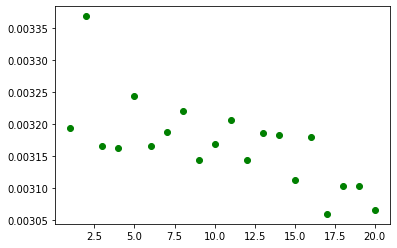


Test Accuracy = 0.8472

Total time taken (in seconds): 360.29
======================= Trial: 3 =======================

Train Accuracy: 0.8416
Number of Epoch = 1 - Average Cross Entropy:= 0.0031568136596679688 

Validation Accuracy: 0.8276

Train Accuracy: 0.8456
Number of Epoch = 2 - Average Cross Entropy:= 0.003548782653808594 

Validation Accuracy: 0.8314

Train Accuracy: 0.8520
Number of Epoch = 3 - Average Cross Entropy:= 0.0034813458251953125 

Validation Accuracy: 0.8384

Train Accuracy: 0.8582
Number of Epoch = 4 - Average Cross Entropy:= 0.0034477432250976563 

Validation Accuracy: 0.8422

Train Accuracy: 0.8602
Number of Epoch = 5 - Average Cross Entropy:= 0.0032912393188476562 

Validation Accuracy: 0.8459

Train Accuracy: 0.8656
Number of Epoch = 6 - Average Cross Entropy:= 0.0032185693359375 

Validation Accuracy: 0.8520

Train Accuracy: 0.8573
Number of Epoch = 7 - Average Cross Entropy:= 0.0032875332641601565 

Validation Accuracy: 0.8415

Train Accuracy: 0.8614
Number

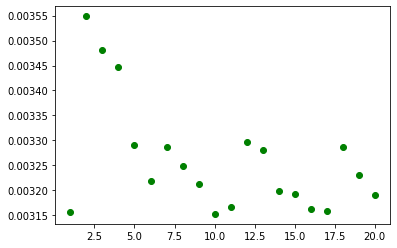


Test Accuracy = 0.8119

Total time taken (in seconds): 358.37
======================= Trial: 4 =======================

Train Accuracy: 0.8618
Number of Epoch = 1 - Average Cross Entropy:= 0.00305721435546875 

Validation Accuracy: 0.8469

Train Accuracy: 0.8669
Number of Epoch = 2 - Average Cross Entropy:= 0.00309322509765625 

Validation Accuracy: 0.8560

Train Accuracy: 0.8659
Number of Epoch = 3 - Average Cross Entropy:= 0.003075784606933594 

Validation Accuracy: 0.8524

Train Accuracy: 0.8645
Number of Epoch = 4 - Average Cross Entropy:= 0.003062098083496094 

Validation Accuracy: 0.8469

Train Accuracy: 0.8568
Number of Epoch = 5 - Average Cross Entropy:= 0.0031082977294921875 

Validation Accuracy: 0.8423

Train Accuracy: 0.8662
Number of Epoch = 6 - Average Cross Entropy:= 0.0031693826293945314 

Validation Accuracy: 0.8512

Train Accuracy: 0.8690
Number of Epoch = 7 - Average Cross Entropy:= 0.0031366888427734373 

Validation Accuracy: 0.8554

Train Accuracy: 0.8643
Number o

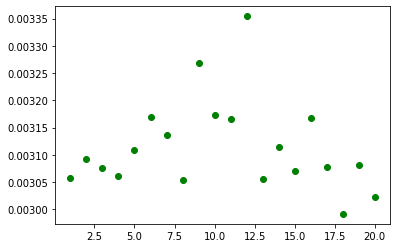


Test Accuracy = 0.8383

Total time taken (in seconds): 363.07
======================= Trial: 5 =======================

Train Accuracy: 0.8654
Number of Epoch = 1 - Average Cross Entropy:= 0.0030442083740234373 

Validation Accuracy: 0.8500

Train Accuracy: 0.8646
Number of Epoch = 2 - Average Cross Entropy:= 0.0032453250122070313 

Validation Accuracy: 0.8503

Train Accuracy: 0.8635
Number of Epoch = 3 - Average Cross Entropy:= 0.003123428649902344 

Validation Accuracy: 0.8490

Train Accuracy: 0.8636
Number of Epoch = 4 - Average Cross Entropy:= 0.00309615478515625 

Validation Accuracy: 0.8463

Train Accuracy: 0.8596
Number of Epoch = 5 - Average Cross Entropy:= 0.0030314630126953125 

Validation Accuracy: 0.8446

Train Accuracy: 0.8651
Number of Epoch = 6 - Average Cross Entropy:= 0.003071510009765625 

Validation Accuracy: 0.8462

Train Accuracy: 0.8590
Number of Epoch = 7 - Average Cross Entropy:= 0.00314447509765625 

Validation Accuracy: 0.8449

Train Accuracy: 0.8591
Number o

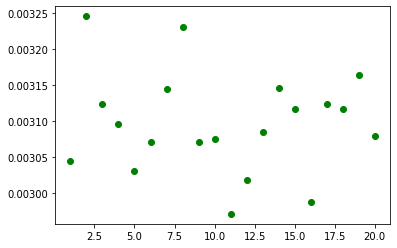


Test Accuracy = 0.8378

Total time taken (in seconds): 367.94
======================= Trial: 6 =======================

Train Accuracy: 0.8589
Number of Epoch = 1 - Average Cross Entropy:= 0.0030362838745117185 

Validation Accuracy: 0.8407

Train Accuracy: 0.8672
Number of Epoch = 2 - Average Cross Entropy:= 0.0031933364868164064 

Validation Accuracy: 0.8491

Train Accuracy: 0.8667
Number of Epoch = 3 - Average Cross Entropy:= 0.0030710592651367187 

Validation Accuracy: 0.8464

Train Accuracy: 0.8702
Number of Epoch = 4 - Average Cross Entropy:= 0.003008781433105469 

Validation Accuracy: 0.8500

Train Accuracy: 0.8623
Number of Epoch = 5 - Average Cross Entropy:= 0.002976788024902344 

Validation Accuracy: 0.8450

Train Accuracy: 0.8706
Number of Epoch = 6 - Average Cross Entropy:= 0.002979278564453125 

Validation Accuracy: 0.8528

Train Accuracy: 0.8684
Number of Epoch = 7 - Average Cross Entropy:= 0.0030370135498046873 

Validation Accuracy: 0.8479

Train Accuracy: 0.8605
Numbe

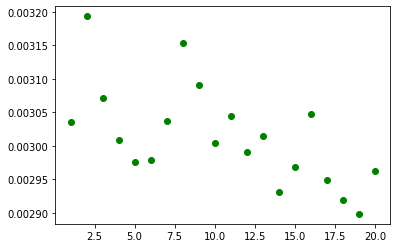


Test Accuracy = 0.845

Total time taken (in seconds): 359.66
======================= Trial: 7 =======================

Train Accuracy: 0.8577
Number of Epoch = 1 - Average Cross Entropy:= 0.0030763934326171875 

Validation Accuracy: 0.8400

Train Accuracy: 0.8659
Number of Epoch = 2 - Average Cross Entropy:= 0.00307653564453125 

Validation Accuracy: 0.8421

Train Accuracy: 0.8730
Number of Epoch = 3 - Average Cross Entropy:= 0.0032285079956054685 

Validation Accuracy: 0.8502

Train Accuracy: 0.8714
Number of Epoch = 4 - Average Cross Entropy:= 0.002953316650390625 

Validation Accuracy: 0.8515

Train Accuracy: 0.8646
Number of Epoch = 5 - Average Cross Entropy:= 0.002941043395996094 

Validation Accuracy: 0.8423

Train Accuracy: 0.8699
Number of Epoch = 6 - Average Cross Entropy:= 0.0029224053955078126 

Validation Accuracy: 0.8487

Train Accuracy: 0.8504
Number of Epoch = 7 - Average Cross Entropy:= 0.002934081115722656 

Validation Accuracy: 0.8325

Train Accuracy: 0.8739
Number o

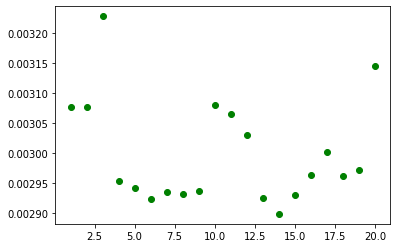


Test Accuracy = 0.8374

Total time taken (in seconds): 361.04
======================= Trial: 8 =======================

Train Accuracy: 0.8627
Number of Epoch = 1 - Average Cross Entropy:= 0.0031783270263671874 

Validation Accuracy: 0.8453

Train Accuracy: 0.8710
Number of Epoch = 2 - Average Cross Entropy:= 0.003124102783203125 

Validation Accuracy: 0.8539

Train Accuracy: 0.8523
Number of Epoch = 3 - Average Cross Entropy:= 0.0032857595825195314 

Validation Accuracy: 0.8349

Train Accuracy: 0.8588
Number of Epoch = 4 - Average Cross Entropy:= 0.0029754275512695314 

Validation Accuracy: 0.8379

Train Accuracy: 0.8697
Number of Epoch = 5 - Average Cross Entropy:= 0.0029333575439453126 

Validation Accuracy: 0.8515

Train Accuracy: 0.8671
Number of Epoch = 6 - Average Cross Entropy:= 0.002844237365722656 

Validation Accuracy: 0.8465

Train Accuracy: 0.8650
Number of Epoch = 7 - Average Cross Entropy:= 0.0030164859008789064 

Validation Accuracy: 0.8468

Train Accuracy: 0.8602
Numb

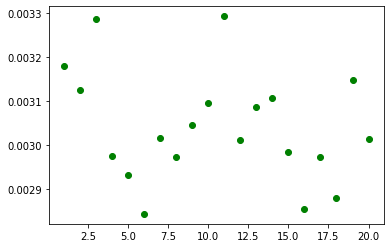


Test Accuracy = 0.8376

Total time taken (in seconds): 362.58
======================= Trial: 9 =======================

Train Accuracy: 0.8590
Number of Epoch = 1 - Average Cross Entropy:= 0.003000785827636719 

Validation Accuracy: 0.8387

Train Accuracy: 0.8707
Number of Epoch = 2 - Average Cross Entropy:= 0.0029409075927734375 

Validation Accuracy: 0.8475

Train Accuracy: 0.8696
Number of Epoch = 3 - Average Cross Entropy:= 0.0030465191650390624 

Validation Accuracy: 0.8481

Train Accuracy: 0.8723
Number of Epoch = 4 - Average Cross Entropy:= 0.0029689578247070313 

Validation Accuracy: 0.8517

Train Accuracy: 0.8694
Number of Epoch = 5 - Average Cross Entropy:= 0.0028958706665039064 

Validation Accuracy: 0.8489

Train Accuracy: 0.8650
Number of Epoch = 6 - Average Cross Entropy:= 0.0030460003662109375 

Validation Accuracy: 0.8441

Train Accuracy: 0.8705
Number of Epoch = 7 - Average Cross Entropy:= 0.0028853192138671873 

Validation Accuracy: 0.8487

Train Accuracy: 0.8678
Num

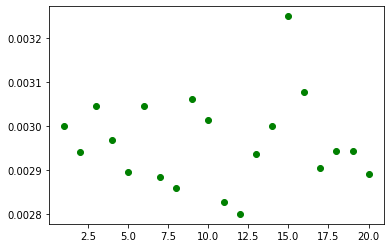


Test Accuracy = 0.8445

Total time taken (in seconds): 367.99
======================= Trial: 10 =======================

Train Accuracy: 0.8632
Number of Epoch = 1 - Average Cross Entropy:= 0.003110288391113281 

Validation Accuracy: 0.8434

Train Accuracy: 0.8677
Number of Epoch = 2 - Average Cross Entropy:= 0.003029526672363281 

Validation Accuracy: 0.8472

Train Accuracy: 0.8785
Number of Epoch = 3 - Average Cross Entropy:= 0.0028380517578125 

Validation Accuracy: 0.8565

Train Accuracy: 0.8753
Number of Epoch = 4 - Average Cross Entropy:= 0.002866502990722656 

Validation Accuracy: 0.8535

Train Accuracy: 0.8780
Number of Epoch = 5 - Average Cross Entropy:= 0.0029137554931640626 

Validation Accuracy: 0.8550

Train Accuracy: 0.8724
Number of Epoch = 6 - Average Cross Entropy:= 0.002880296936035156 

Validation Accuracy: 0.8536

Train Accuracy: 0.8709
Number of Epoch = 7 - Average Cross Entropy:= 0.0029082080078125 

Validation Accuracy: 0.8486

Train Accuracy: 0.8714
Number of E

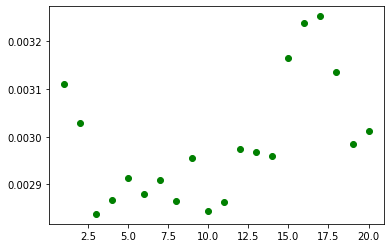


Test Accuracy = 0.8287

Total time taken (in seconds): 361.29

Total time take (in seconds): 3629.47
Test Accuracy [0.8145, 0.8472, 0.8119, 0.8383, 0.8378, 0.845, 0.8374, 0.8376, 0.8445, 0.8287]


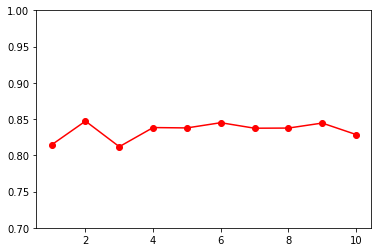

In [ ]:
# 10 Trials for Stability Test
# Set number of epochs
NUM_EPOCHS = 20

lr = 0.01
dropout_p = 0.2
L2 = 0.0

# seeds = 9630
seeds = np.random.randint(1000,9999,10)
test_acc_total = []

# Initialize model using CPU
mlp_on_cpu = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device='gpu')

time_start_total = time.time()

for i in range(len(seeds)):
  time_start = time.time()
  seed = seeds[i]
  print('======================= Trial:', i+1, '=======================')
  for epoch in range(NUM_EPOCHS):
      
    loss_total = tf.zeros([1,1], dtype=tf.float32)
    lt = 0
      
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(seed)).batch(128)
    kz = 0
    accuracy_z = 0.0
    cur_train_acc = 0.0
    for inputs, outputs in train_ds:
      qw, tr = tf.shape(inputs)
      kz = kz + 1
      preds = mlp_on_cpu.forward(0, inputs) 
      loss_total = loss_total + mlp_on_cpu.loss(preds, outputs)
      lt = lt + mlp_on_cpu.loss(preds, outputs)
      mlp_on_cpu.backward(inputs, outputs)

    preds = mlp_on_cpu.forward(0, X_train)
    # Get probs, remember we only have logits from our forward function, we need to apply softmax on top of it to get probs
    preds = tf.nn.softmax(preds)
    correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(y_train, 1))
    accuracy_z = accuracy_z + tf.reduce_mean(tf.cast(correct_prediction, "float"))
    cur_train_acc += accuracy_z.numpy()
    ds = cur_train_acc
    print('\nTrain Accuracy: {:.4f}'.format(ds))
    print('Number of Epoch = {} - Average Cross Entropy:= {} '.format(epoch + 1, np.sum(loss_total) / X_train.shape[0]))
    
    preds_val = mlp_on_cpu.forward(0, X_val)
    preds_val = tf.nn.softmax(preds_val)
    correct_prediction = tf.equal(tf.argmax(preds_val, 1), tf.argmax(y_val, 1))

    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    cur_val_acc = accuracy.numpy()

    print('\nValidation Accuracy: {:.4f}'.format(cur_val_acc))
    
    plt.plot(epoch + 1, np.sum(loss_total) / X_train.shape[0], 'go')

  plt.show()        
  time_taken = time.time() - time_start
      
  # Validate model
      
  # Test Model
  preds = mlp_on_cpu.forward(0, X_test)
  pred = np.argmax(preds, axis = 1)
  y_true = np.argmax(y_test, axis = 1)
  test_acc = (pred==y_true).mean()
  test_acc_total.append(test_acc)

  print('\nTest Accuracy = {}'.format(test_acc))

  print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
  #For per epoch_time = Total_Time / Number_of_epochs

print('\nTotal time take (in seconds): {:.2f}'.format(time.time() - time_start_total))
print('Test Accuracy', test_acc_total)
plt_x = [1,2,3,4,5,6,7,8,9,10]
plt.ylim(0.7, 1.0)
plt.plot(plt_x, test_acc_total, 'ro-')
plt.show()

# L2 Regularization

======================= Trial: 1 =======================

Train Accuracy: 0.6934
Number of Epoch = 1 - Average Cross Entropy:= 0.01938874267578125 

Validation Accuracy: 0.6854

Train Accuracy: 0.6998
Number of Epoch = 2 - Average Cross Entropy:= 0.008444336547851563 

Validation Accuracy: 0.6909

Train Accuracy: 0.7124
Number of Epoch = 3 - Average Cross Entropy:= 0.008006370239257812 

Validation Accuracy: 0.7022

Train Accuracy: 0.7027
Number of Epoch = 4 - Average Cross Entropy:= 0.0077701556396484375 

Validation Accuracy: 0.6959

Train Accuracy: 0.7253
Number of Epoch = 5 - Average Cross Entropy:= 0.007560557250976562 

Validation Accuracy: 0.7147

Train Accuracy: 0.7085
Number of Epoch = 6 - Average Cross Entropy:= 0.007391868896484375 

Validation Accuracy: 0.6968

Train Accuracy: 0.7500
Number of Epoch = 7 - Average Cross Entropy:= 0.007363515625 

Validation Accuracy: 0.7455

Train Accuracy: 0.7479
Number of Epoch = 8 - Average Cross Entropy:= 0.0071887286376953125 

Validati

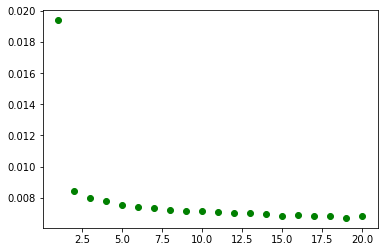


Test Accuracy = 0.7595

Total time taken (in seconds): 350.62
======================= Trial: 2 =======================

Train Accuracy: 0.7359
Number of Epoch = 1 - Average Cross Entropy:= 0.007043787841796875 

Validation Accuracy: 0.7265

Train Accuracy: 0.7351
Number of Epoch = 2 - Average Cross Entropy:= 0.0068017608642578125 

Validation Accuracy: 0.7231

Train Accuracy: 0.7626
Number of Epoch = 3 - Average Cross Entropy:= 0.006769688720703125 

Validation Accuracy: 0.7511

Train Accuracy: 0.7750
Number of Epoch = 4 - Average Cross Entropy:= 0.006745728759765625 

Validation Accuracy: 0.7658

Train Accuracy: 0.7375
Number of Epoch = 5 - Average Cross Entropy:= 0.006578300170898437 

Validation Accuracy: 0.7288

Train Accuracy: 0.7438
Number of Epoch = 6 - Average Cross Entropy:= 0.006685155639648437 

Validation Accuracy: 0.7367

Train Accuracy: 0.7786
Number of Epoch = 7 - Average Cross Entropy:= 0.006710684204101563 

Validation Accuracy: 0.7680

Train Accuracy: 0.7530
Number o

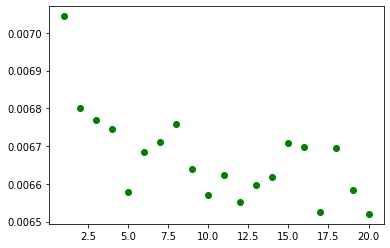


Test Accuracy = 0.7599

Total time taken (in seconds): 346.73
======================= Trial: 3 =======================

Train Accuracy: 0.7807
Number of Epoch = 1 - Average Cross Entropy:= 0.00660451171875 

Validation Accuracy: 0.7718

Train Accuracy: 0.7542
Number of Epoch = 2 - Average Cross Entropy:= 0.006615230102539063 

Validation Accuracy: 0.7511

Train Accuracy: 0.7929
Number of Epoch = 3 - Average Cross Entropy:= 0.0065382763671875 

Validation Accuracy: 0.7879

Train Accuracy: 0.7758
Number of Epoch = 4 - Average Cross Entropy:= 0.006606715087890625 

Validation Accuracy: 0.7675

Train Accuracy: 0.7531
Number of Epoch = 5 - Average Cross Entropy:= 0.006639048461914062 

Validation Accuracy: 0.7442

Train Accuracy: 0.7716
Number of Epoch = 6 - Average Cross Entropy:= 0.006589476318359375 

Validation Accuracy: 0.7665

Train Accuracy: 0.7762
Number of Epoch = 7 - Average Cross Entropy:= 0.006581497802734375 

Validation Accuracy: 0.7742

Train Accuracy: 0.7289
Number of Epoch

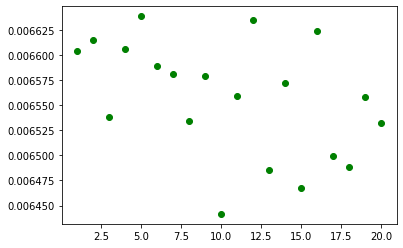


Test Accuracy = 0.7705

Total time taken (in seconds): 340.95
======================= Trial: 4 =======================

Train Accuracy: 0.7802
Number of Epoch = 1 - Average Cross Entropy:= 0.00652404541015625 

Validation Accuracy: 0.7748

Train Accuracy: 0.7681
Number of Epoch = 2 - Average Cross Entropy:= 0.006447756958007813 

Validation Accuracy: 0.7575

Train Accuracy: 0.7567
Number of Epoch = 3 - Average Cross Entropy:= 0.006585980224609375 

Validation Accuracy: 0.7518

Train Accuracy: 0.7591
Number of Epoch = 4 - Average Cross Entropy:= 0.006453375854492188 

Validation Accuracy: 0.7525

Train Accuracy: 0.7781
Number of Epoch = 5 - Average Cross Entropy:= 0.0064902294921875 

Validation Accuracy: 0.7714

Train Accuracy: 0.7824
Number of Epoch = 6 - Average Cross Entropy:= 0.006470979614257812 

Validation Accuracy: 0.7753

Train Accuracy: 0.7156
Number of Epoch = 7 - Average Cross Entropy:= 0.006563695678710938 

Validation Accuracy: 0.7081

Train Accuracy: 0.6783
Number of Ep

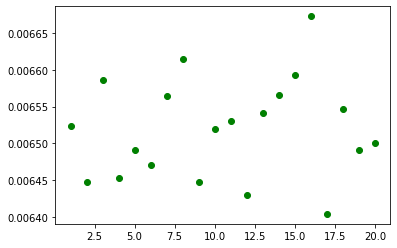


Test Accuracy = 0.7685

Total time taken (in seconds): 344.94
======================= Trial: 5 =======================

Train Accuracy: 0.7428
Number of Epoch = 1 - Average Cross Entropy:= 0.006485761108398437 

Validation Accuracy: 0.7330

Train Accuracy: 0.7887
Number of Epoch = 2 - Average Cross Entropy:= 0.006470079956054688 

Validation Accuracy: 0.7876

Train Accuracy: 0.7810
Number of Epoch = 3 - Average Cross Entropy:= 0.00645288330078125 

Validation Accuracy: 0.7749

Train Accuracy: 0.7717
Number of Epoch = 4 - Average Cross Entropy:= 0.006399522705078125 

Validation Accuracy: 0.7702

Train Accuracy: 0.7824
Number of Epoch = 5 - Average Cross Entropy:= 0.006431375122070313 

Validation Accuracy: 0.7789

Train Accuracy: 0.7783
Number of Epoch = 6 - Average Cross Entropy:= 0.00650659423828125 

Validation Accuracy: 0.7790

Train Accuracy: 0.7401
Number of Epoch = 7 - Average Cross Entropy:= 0.00652830078125 

Validation Accuracy: 0.7328

Train Accuracy: 0.7767
Number of Epoch

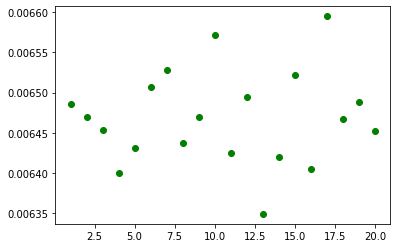


Test Accuracy = 0.7552

Total time taken (in seconds): 345.02
======================= Trial: 6 =======================

Train Accuracy: 0.7700
Number of Epoch = 1 - Average Cross Entropy:= 0.006401505737304688 

Validation Accuracy: 0.7626

Train Accuracy: 0.7863
Number of Epoch = 2 - Average Cross Entropy:= 0.006456597290039063 

Validation Accuracy: 0.7791

Train Accuracy: 0.7490
Number of Epoch = 3 - Average Cross Entropy:= 0.006474860229492187 

Validation Accuracy: 0.7450

Train Accuracy: 0.7740
Number of Epoch = 4 - Average Cross Entropy:= 0.00643146728515625 

Validation Accuracy: 0.7643

Train Accuracy: 0.7848
Number of Epoch = 5 - Average Cross Entropy:= 0.006429896850585938 

Validation Accuracy: 0.7771

Train Accuracy: 0.7613
Number of Epoch = 6 - Average Cross Entropy:= 0.006423258056640625 

Validation Accuracy: 0.7569

Train Accuracy: 0.7255
Number of Epoch = 7 - Average Cross Entropy:= 0.006586936645507813 

Validation Accuracy: 0.7196

Train Accuracy: 0.7886
Number of 

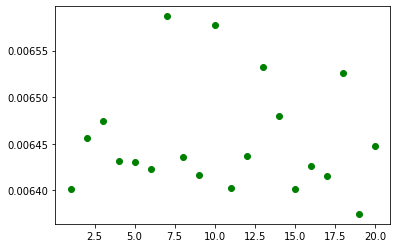


Test Accuracy = 0.7611

Total time taken (in seconds): 342.41
======================= Trial: 7 =======================

Train Accuracy: 0.7492
Number of Epoch = 1 - Average Cross Entropy:= 0.006406915893554688 

Validation Accuracy: 0.7459

Train Accuracy: 0.7780
Number of Epoch = 2 - Average Cross Entropy:= 0.00648819091796875 

Validation Accuracy: 0.7724

Train Accuracy: 0.7878
Number of Epoch = 3 - Average Cross Entropy:= 0.006434525756835938 

Validation Accuracy: 0.7812

Train Accuracy: 0.7555
Number of Epoch = 4 - Average Cross Entropy:= 0.00643096435546875 

Validation Accuracy: 0.7493

Train Accuracy: 0.7906
Number of Epoch = 5 - Average Cross Entropy:= 0.0063247381591796875 

Validation Accuracy: 0.7869

Train Accuracy: 0.7121
Number of Epoch = 6 - Average Cross Entropy:= 0.006489557495117188 

Validation Accuracy: 0.7057

Train Accuracy: 0.7930
Number of Epoch = 7 - Average Cross Entropy:= 0.006536630859375 

Validation Accuracy: 0.7896

Train Accuracy: 0.7702
Number of Epo

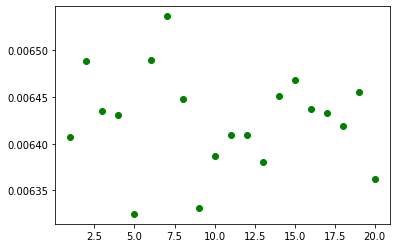


Test Accuracy = 0.7551

Total time taken (in seconds): 344.49
======================= Trial: 8 =======================

Train Accuracy: 0.7818
Number of Epoch = 1 - Average Cross Entropy:= 0.006452586669921875 

Validation Accuracy: 0.7807

Train Accuracy: 0.7720
Number of Epoch = 2 - Average Cross Entropy:= 0.006416865234375 

Validation Accuracy: 0.7666

Train Accuracy: 0.7914
Number of Epoch = 3 - Average Cross Entropy:= 0.0063360101318359376 

Validation Accuracy: 0.7865

Train Accuracy: 0.7602
Number of Epoch = 4 - Average Cross Entropy:= 0.006469661254882813 

Validation Accuracy: 0.7544

Train Accuracy: 0.7739
Number of Epoch = 5 - Average Cross Entropy:= 0.006390833740234375 

Validation Accuracy: 0.7733

Train Accuracy: 0.7480
Number of Epoch = 6 - Average Cross Entropy:= 0.00638440673828125 

Validation Accuracy: 0.7380

Train Accuracy: 0.7938
Number of Epoch = 7 - Average Cross Entropy:= 0.006390623779296875 

Validation Accuracy: 0.7870

Train Accuracy: 0.7788
Number of Ep

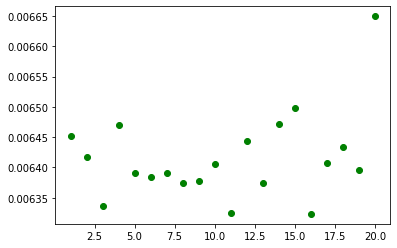


Test Accuracy = 0.7342

Total time taken (in seconds): 342.66
======================= Trial: 9 =======================

Train Accuracy: 0.7505
Number of Epoch = 1 - Average Cross Entropy:= 0.006411567993164062 

Validation Accuracy: 0.7435

Train Accuracy: 0.7740
Number of Epoch = 2 - Average Cross Entropy:= 0.006337353515625 

Validation Accuracy: 0.7657

Train Accuracy: 0.7472
Number of Epoch = 3 - Average Cross Entropy:= 0.0064302899169921875 

Validation Accuracy: 0.7419

Train Accuracy: 0.7411
Number of Epoch = 4 - Average Cross Entropy:= 0.006381596069335938 

Validation Accuracy: 0.7350

Train Accuracy: 0.7802
Number of Epoch = 5 - Average Cross Entropy:= 0.0063452294921875 

Validation Accuracy: 0.7770

Train Accuracy: 0.7295
Number of Epoch = 6 - Average Cross Entropy:= 0.00655316650390625 

Validation Accuracy: 0.7265

Train Accuracy: 0.7655
Number of Epoch = 7 - Average Cross Entropy:= 0.006440409545898438 

Validation Accuracy: 0.7603

Train Accuracy: 0.7759
Number of Epoc

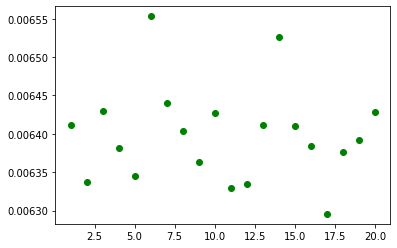


Test Accuracy = 0.7831

Total time taken (in seconds): 343.41
======================= Trial: 10 =======================

Train Accuracy: 0.7049
Number of Epoch = 1 - Average Cross Entropy:= 0.006402162475585937 

Validation Accuracy: 0.6978

Train Accuracy: 0.7256
Number of Epoch = 2 - Average Cross Entropy:= 0.006358626708984375 

Validation Accuracy: 0.7179

Train Accuracy: 0.6904
Number of Epoch = 3 - Average Cross Entropy:= 0.006409163208007812 

Validation Accuracy: 0.6852

Train Accuracy: 0.7548
Number of Epoch = 4 - Average Cross Entropy:= 0.006473093872070313 

Validation Accuracy: 0.7493

Train Accuracy: 0.7453
Number of Epoch = 5 - Average Cross Entropy:= 0.006406743774414063 

Validation Accuracy: 0.7383

Train Accuracy: 0.7925
Number of Epoch = 6 - Average Cross Entropy:= 0.00639396728515625 

Validation Accuracy: 0.7878

Train Accuracy: 0.7515
Number of Epoch = 7 - Average Cross Entropy:= 0.006404857177734375 

Validation Accuracy: 0.7442

Train Accuracy: 0.6994
Number of

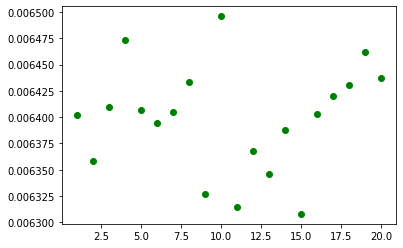


Test Accuracy = 0.7372

Total time taken (in seconds): 344.27

Total time take (in seconds): 3445.65
Test Accuracy [0.7595, 0.7599, 0.7705, 0.7685, 0.7552, 0.7611, 0.7551, 0.7342, 0.7831, 0.7372]


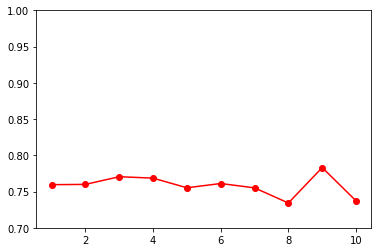

In [ ]:
# 10 Trials for Stability Test
# Set number of epochs
NUM_EPOCHS = 20

lr = 0.01
dropout_p = 0.0
L2 = 0.05

seeds = [9630]
seeds = np.random.randint(1000,9999,10)
test_acc_total = []

# Initialize model using CPU
mlp_on_cpu = MLP(size_input, size_hidden1, size_hidden2, size_hidden3, size_output, device='gpu')

time_start_total = time.time()

for i in range(len(seeds)):
  time_start = time.time()
  seed = seeds[i]
  print('======================= Trial:', i+1, '=======================')
  for epoch in range(NUM_EPOCHS):
      
    loss_total = tf.zeros([1,1], dtype=tf.float32)
    lt = 0
      
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*(seed)).batch(128)
    kz = 0
    accuracy_z = 0.0
    cur_train_acc = 0.0
    for inputs, outputs in train_ds:
      qw, tr = tf.shape(inputs)
      kz = kz + 1
      preds = mlp_on_cpu.forward(0, inputs) 
      loss_total = loss_total + mlp_on_cpu.loss(preds, outputs)
      lt = lt + mlp_on_cpu.loss(preds, outputs)
      mlp_on_cpu.backward(inputs, outputs)

    preds = mlp_on_cpu.forward(0, X_train)
    # Get probs, remember we only have logits from our forward function, we need to apply softmax on top of it to get probs
    preds = tf.nn.softmax(preds)
    correct_prediction = tf.equal(tf.argmax(preds, 1), tf.argmax(y_train, 1))
    accuracy_z = accuracy_z + tf.reduce_mean(tf.cast(correct_prediction, "float"))
    cur_train_acc += accuracy_z.numpy()
    ds = cur_train_acc
    print('\nTrain Accuracy: {:.4f}'.format(ds))
    print('Number of Epoch = {} - Average Cross Entropy:= {} '.format(epoch + 1, np.sum(loss_total) / X_train.shape[0]))
    
    preds_val = mlp_on_cpu.forward(0, X_val)
    preds_val = tf.nn.softmax(preds_val)
    correct_prediction = tf.equal(tf.argmax(preds_val, 1), tf.argmax(y_val, 1))

    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    cur_val_acc = accuracy.numpy()

    print('\nValidation Accuracy: {:.4f}'.format(cur_val_acc))
    
    plt.plot(epoch + 1, np.sum(loss_total) / X_train.shape[0], 'go')

  plt.show()        
  time_taken = time.time() - time_start
      
  # Validate model
      
  # Test Model
  preds = mlp_on_cpu.forward(0, X_test)
  pred = np.argmax(preds, axis = 1)
  y_true = np.argmax(y_test, axis = 1)
  test_acc = (pred==y_true).mean()
  test_acc_total.append(test_acc)

  print('\nTest Accuracy = {}'.format(test_acc))

  print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
  #For per epoch_time = Total_Time / Number_of_epochs

print('\nTotal time take (in seconds): {:.2f}'.format(time.time() - time_start_total))
print('Test Accuracy', test_acc_total)
plt_x = [1,2,3,4,5,6,7,8,9,10]
plt.ylim(0.7, 1.0)
plt.plot(plt_x, test_acc_total, 'ro-')
plt.show()